In [1]:
# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

# libraries
import numpy as np
import pandas as pd

# For Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#### Reading Cancer data

In [2]:
import pickle
file = open("data_RUS_risk2_dummy","rb")
X_train = pickle.load(file)
y_train = pickle.load(file)
X_test = pickle.load(file)
y_test = pickle.load(file)
file.close()

In [3]:
X_train.head(2)

,menopaus_0,agegrp_2,agegrp_3,agegrp_4,agegrp_5,agegrp_6,agegrp_7,agegrp_8,agegrp_9,agegrp_10,...,race_5,hispanic_0,hispanic_1,bmi_3,bmi_4,agefirst_1,agefirst_2,nrelbc_0,nrelbc_2,lastmamm_1
0,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0


In [4]:
X_test.head(2)

,menopaus_0,agegrp_2,agegrp_3,agegrp_4,agegrp_5,agegrp_6,agegrp_7,agegrp_8,agegrp_9,agegrp_10,...,race_5,hispanic_0,hispanic_1,bmi_3,bmi_4,agefirst_1,agefirst_2,nrelbc_0,nrelbc_2,lastmamm_1
1,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
9,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


In [5]:
X_train.shape

(8586, 25)

In [6]:
X_test.shape

(59501, 25)

# Model Building on Cancer Data

## <span style="color:blue">Model 3 - SVM with SGD</span>

### Default Hyperparameters

Let's first fit a random forest model with default hyperparameters.

In [7]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score

def model_stats(X, y, y_pred, model):

    cm = confusion_matrix(y, y_pred)
    print("Confusion Matrix ->")
    print(cm)

    TP = cm[1,1] # true positive 
    TN = cm[0,0] # true negatives
    FP = cm[0,1] # false positives
    FN = cm[1,0] # false negatives
    
    print("Accuracy:",accuracy_score(y, y_pred))
    sensi=TP / float(TP+FN)
    speci=TN / float(TN+FP)
    # Let's see the sensitivity of our model
    print("Sensitivity:", sensi)

    # Let us calculate specificity
    print("Specificity:", speci)
    print("Average of Sensitivity and Specificity:", (sensi+speci)/2)

    # Let us calculate precision
    print("Precision",TP / float(TP+FP))
    print("MCC ", metrics.matthews_corrcoef(y, y_pred))
    print("F1 ", metrics.fbeta_score(y, y_pred, beta = 1))
    print("F2 ", metrics.fbeta_score(y, y_pred, beta = 2))
    print("F3 ", metrics.fbeta_score(y, y_pred, beta = 3))
    
    # Predicting probability for roc_auc
    '''pred_probs = model.predict_proba(X)[:,1]
    print("ROC-AUC : {:2.2}".format(roc_auc_score(y, pred_probs)))

    # Plotting ROC curve
    fpr, tpr, thresholds = roc_curve(y, pred_probs, drop_intermediate = False )
    auc_score = roc_auc_score(y, pred_probs)
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()'''
    

In [8]:
# Importing random forest classifier from sklearn library
from sklearn.linear_model import SGDClassifier

In [9]:
sgd = SGDClassifier(random_state = 100)

# fit
sgd.fit(X_train,y_train)

SGDClassifier(random_state=100)

In [10]:
# Let's check the evaluation metrics of our default model

# Making predictions
y_pred_train_def = sgd.predict(X_train) # For train data
y_pred_test_def = sgd.predict(X_test) # For test data

#### Evaluating model on imbalanced train data with default parameters

In [11]:
# For train
model_stats(X_train, y_train, y_pred_train_def, sgd)

Confusion Matrix ->
[[2622 1671]
 [1080 3213]]
Accuracy: 0.6795946890286513
Sensitivity: 0.7484276729559748
Specificity: 0.6107617051013278
Average of Sensitivity and Specificity: 0.6795946890286513
Precision 0.6578624078624079
MCC  0.36264219843579915
F1  0.700228832951945
F2  0.7283732317736671
F3  0.7382642862066588


#### Evaluating model on imbalanced test data with default parameters

In [12]:
# For test
model_stats(X_test, y_test, y_pred_test_def, sgd)

Confusion Matrix ->
[[30499 27431]
 [  383  1188]]
Accuracy: 0.5325456715013193
Sensitivity: 0.7562062380649268
Specificity: 0.5264802347660971
Average of Sensitivity and Specificity: 0.6413432364155119
Precision 0.041510884377511444
MCC  0.09071204279434356
F1  0.0787015568068897
F2  0.17018594390167033
F3  0.2778427428785256


### Hyperparameter Tuning : Grid Search to Find Optimal Hyperparameters


By default the loss is 'hinge'

In [13]:
from sklearn.model_selection import GridSearchCV,StratifiedKFold

#Create a cross validation scheme
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 100)

In [14]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'penalty' : ['l1', 'l2', 'elasticnet'] 
}

sgd = SGDClassifier(random_state = 100)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = sgd, param_grid = param_grid, scoring='balanced_accuracy',
                          cv = folds, n_jobs = -1,verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# printing the optimal accuracy score and hyperparameters
print("best balanced accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


best balanced accuracy 0.6815740914111111
SGDClassifier(penalty='elasticnet', random_state=100)


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.7s finished


In [15]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_iter' : [400, 600, 800] 
}

sgd = SGDClassifier(penalty='elasticnet', random_state = 100)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = sgd, param_grid = param_grid, scoring='balanced_accuracy',
                          cv = folds, n_jobs = -1,verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# printing the optimal accuracy score and hyperparameters
print("best balanced accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


best balanced accuracy 0.6815740914111111
SGDClassifier(max_iter=400, penalty='elasticnet', random_state=100)


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.5s finished


In [16]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'alpha' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000] 
}

sgd = SGDClassifier(penalty='elasticnet', random_state = 100)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = sgd, param_grid = param_grid, scoring='balanced_accuracy',
                          cv = folds, n_jobs = -1,verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# printing the optimal accuracy score and hyperparameters
print("best balanced accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


best balanced accuracy 0.6815740914111111
SGDClassifier(penalty='elasticnet', random_state=100)


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.7s finished


In [17]:
### Model using best parameters obtained from grid search

sgd = SGDClassifier(penalty='elasticnet', random_state = 100)

# Fit the grid search to the data
sgd.fit(X_train, y_train)

SGDClassifier(penalty='elasticnet', random_state=100)

In [18]:
#### Model evaluation on train data

# Predicting on test dataframe using predict
y_pred_train = sgd.predict(X_train)

model_stats(X_train, y_train, y_pred_train, sgd)

Confusion Matrix ->
[[2552 1741]
 [1008 3285]]
Accuracy: 0.6798276263685069
Sensitivity: 0.7651991614255765
Specificity: 0.5944560913114372
Average of Sensitivity and Specificity: 0.6798276263685068
Precision 0.6536012733784321
MCC  0.3650152883486636
F1  0.7050112673033586
F2  0.7399315253626453
F3  0.7523532510363465


In [19]:
sgd.coef_

array([[ 0.89762312,  1.28588092,  0.80002227,  1.45236317,  2.00572231,
         1.46058574,  1.81076807,  1.81083015,  1.52741128,  1.48027469,
        -1.57763966, -0.28018693, -1.75915129, -1.23605026, -1.90671197,
        -1.53574957,  1.07815187, -0.59080697, -0.46440314, -0.79196998,
        -0.5905329 , -0.62560826,  0.66395287, -0.99100231, -1.32185508]])

In [20]:
# List of cols with their coefficients
val=sgd.coef_.reshape(-1)
coef = (pd.DataFrame(val, index=X_train.columns, columns = ['Coefficients'] )).reset_index()
coef = coef.rename(columns={'index':'Features'})
coef = coef.sort_values(by = 'Coefficients', ascending=False)
coef

,Features,Coefficients
4,agegrp_5,2.005722
7,agegrp_8,1.810830
6,agegrp_7,1.810768
8,agegrp_9,1.527411
9,agegrp_10,1.480275
5,agegrp_6,1.460586
3,agegrp_4,1.452363
1,agegrp_2,1.285881
16,hispanic_0,1.078152
0,menopaus_0,0.897623


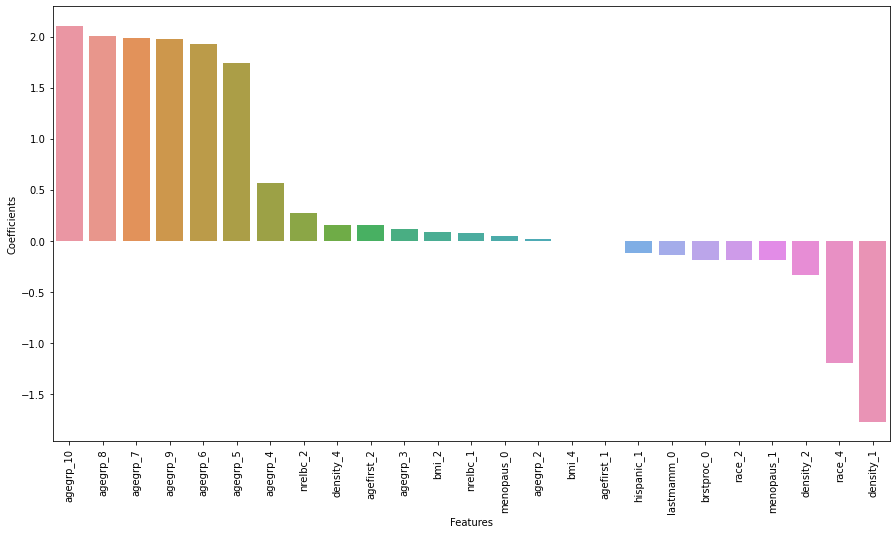

In [23]:
# Plotting important features against their coefficients
plt.figure(figsize=(15,8))
plt.subplot(111)
ax1 = sns.barplot(x = coef['Features'], y = coef['Coefficients'])
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90, fontsize=10)
#plt.ylabel('Coefficients')
plt.show()

#### Model evaluation on test data

In [21]:
# Predicting on test dataframe using predict

y_pred_test = sgd.predict(X_test)
model_stats(X_test, y_test, y_pred_test, sgd)

Confusion Matrix ->
[[29533 28397]
 [  368  1203]]
Accuracy: 0.5165627468445908
Sensitivity: 0.7657542966263526
Specificity: 0.5098049369929225
Average of Sensitivity and Specificity: 0.6377796168096376
Precision 0.04064189189189189
MCC  0.08836211714801552
F1  0.07718712906226942
F2  0.1676234533496823
F3  0.2750405816319531


In [22]:
from sklearn.calibration import CalibratedClassifierCV
ccv = CalibratedClassifierCV(sgd, cv='prefit')
ccv.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(penalty='elasticnet',
                                                    random_state=100),
                       cv='prefit')

In [23]:
# Predicting probability for roc_auc
def cal_roc(model, X, y):
    pred_probs = model.predict_proba(X)[:,1]
    print("ROC-AUC : {:2.2}".format(roc_auc_score(y, pred_probs)))

    # Plotting ROC curve
    fpr, tpr, thresholds = roc_curve(y, pred_probs, drop_intermediate = False )
    auc_score = roc_auc_score(y, pred_probs)
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

ROC-AUC : 0.74


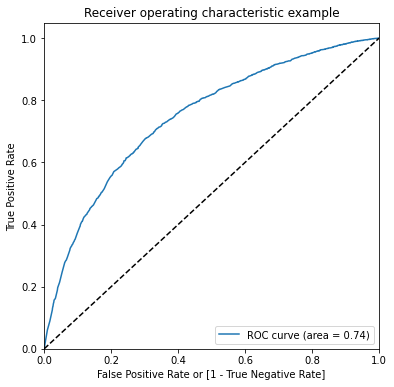

In [24]:
cal_roc(ccv, X_train, y_train)

ROC-AUC : 0.7


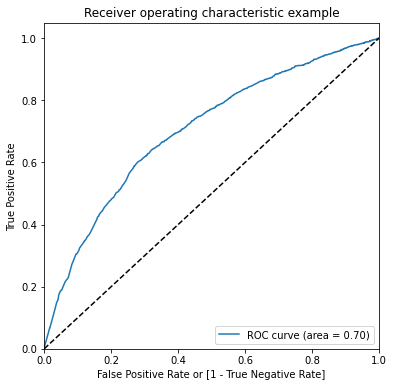

In [25]:
cal_roc(ccv, X_test, y_test)